In [16]:
#!/bin/bash
!kaggle datasets download saurav9786/amazon-product-reviews


Dataset URL: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews
License(s): unknown
 99% 108M/109M [00:00<00:00, 135MB/s] 
100% 109M/109M [00:00<00:00, 122MB/s]


In [17]:
!unzip /content/amazon-product-reviews.zip

Archive:  /content/amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


# **Introduction**
In today’s data-rich world, we are constantly surrounded by vast amounts of information. While this data holds valuable insights, it can be overwhelming, making it difficult for users to pinpoint information relevant to their needs. To assist with this, **recommendation systems** were developed, offering a way to connect users with products and content they’re most likely to enjoy.

Recommendation systems analyze similarities between users and items to generate tailored suggestions.

### What Can a Recommendation System Solve?

- **Product Discovery**: Helps users find the right product efficiently.
- **Increased Engagement**: For instance, Google News saw a 40% increase in clicks due to recommendations.
- **Boost in Sales**: On platforms like Amazon, 35% of sales come from recommended products.
- **Personalized Content**: Platforms such as Netflix report that most rented movies are those suggested by recommendations.

### Types of Recommendation Systems

1. **Popularity-Based Systems**: Recommends items that are popular with the majority of users. These recommendations are not personalized.
  
2. **Classification Model-Based**: Uses classification algorithms to predict if a user might be interested in a product based on user features.

3. **Content-Based Recommendations**: Suggests items based on the content information of items rather than user opinions. If a user enjoys a particular item, similar items are recommended.

4. **Collaborative Filtering**: Assumes users like items similar to those they or others with similar tastes have enjoyed. Types include:
   - **User-User Collaborative Filtering**
   - **Item-Item Collaborative Filtering**

5. **Hybrid Approaches**: Combines collaborative filtering, content-based filtering, and other techniques to improve accuracy and versatility.

6. **Association Rule Mining**: Finds relationships between items based on how often they co-occur across transactions, identifying patterns in user choices.

This categorization highlights the different methods recommendation systems use to provide value to both users and businesses by enhancing discovery, engagement, and personalization.

**Attribute Information:**
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)



# Import Libraries

In [ ]:
# create a file constraints.txt with below line
#```
#fsspec<=2024.9.0
#```
!pip install datasets --constraint constraints.txt
!pip install "gcsfs<2024.10.0"  --constraint constraints.txt # Install a compatible version of gcsfs

In [14]:
import numpy as np
import pandas as pd
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

# Load the Dataset and Add headers

In [18]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [19]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [20]:
#Shape of the data
electronics_data.shape

(7824482, 4)

In [21]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [22]:
#Check the datatypes
electronics_data.dtypes

,0
userId,object
productId,object
Rating,float64
timestamp,int64


In [23]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [24]:
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [25]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [26]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


In [27]:
electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [28]:
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

,Rating
userId,
A5JLAU2ARJ0BO,412
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,164
A6FIAB28IS79,146
AT6CZDCP4TRGA,128


In [29]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

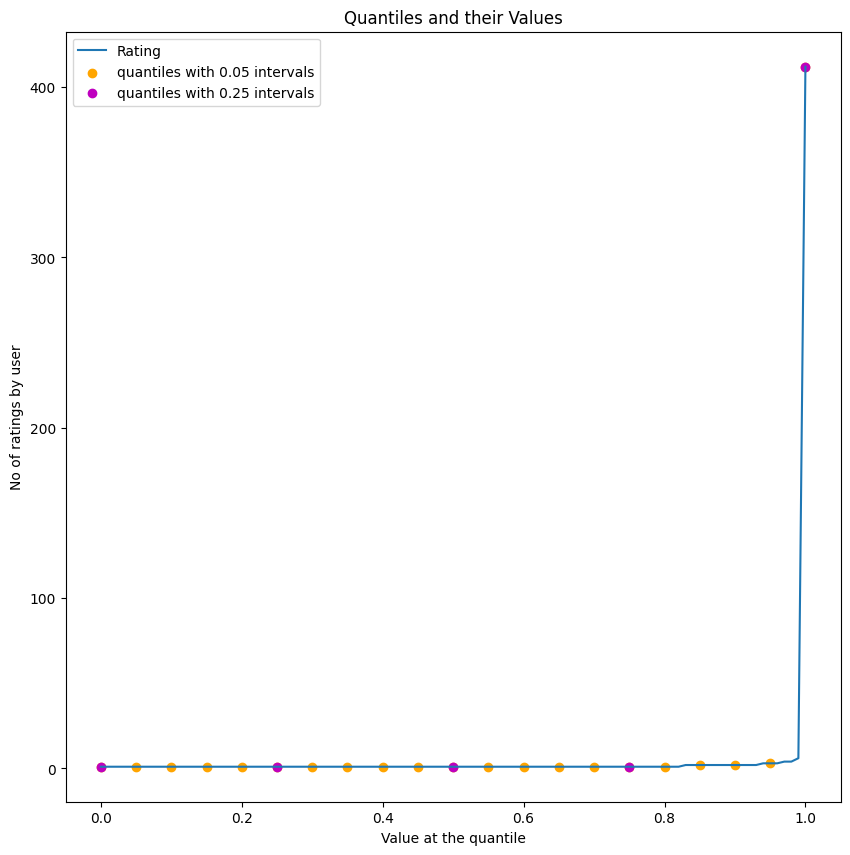

In [30]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [31]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 38



# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [32]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [33]:
new_df.shape

(677947, 3)

In [65]:
new_df[0:3]

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0


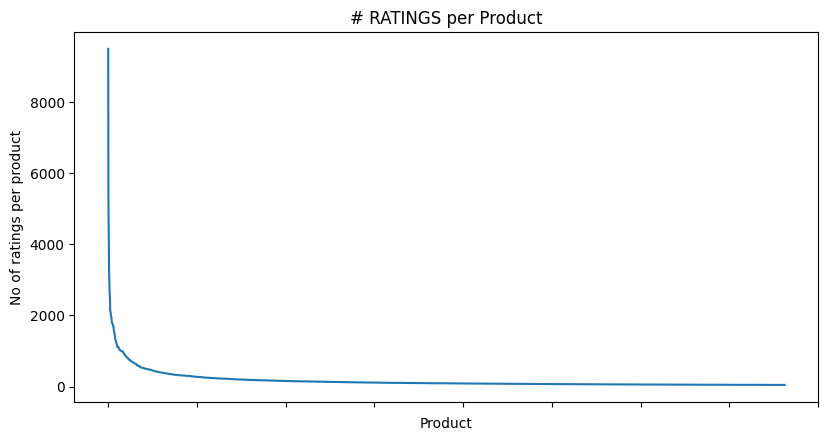

In [34]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [35]:

new_df.groupby('productId')['Rating'].mean().head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [37]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

,Rating
productId,
B0000DYV9H,4.947368
B000053HC5,4.945783
B00009R96C,4.885714
B00005LE76,4.879310
B000I1X3W8,4.869565


In [41]:
new_df.groupby('productId').size().sort_values(ascending=False).head()

,0
productId,
B0002L5R78,9487
B0001FTVEK,5345
B000I68BD4,4903
B000BQ7GW8,4275
B00007E7JU,3523


In [45]:
# new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

In [46]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [47]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [48]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


<Axes: >

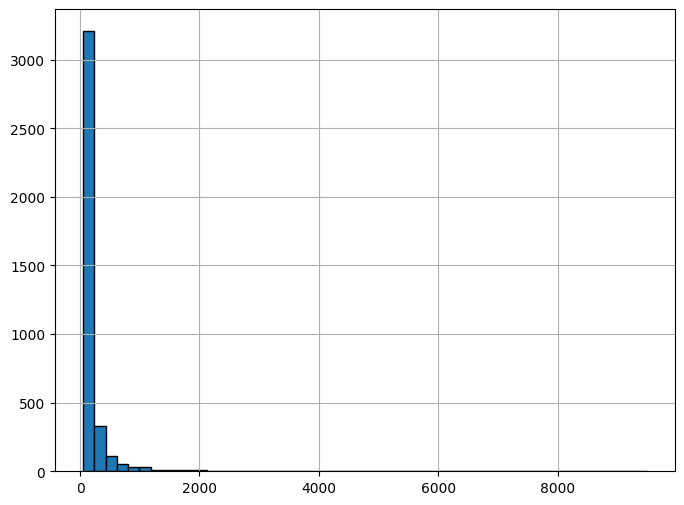

In [49]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Axes: >

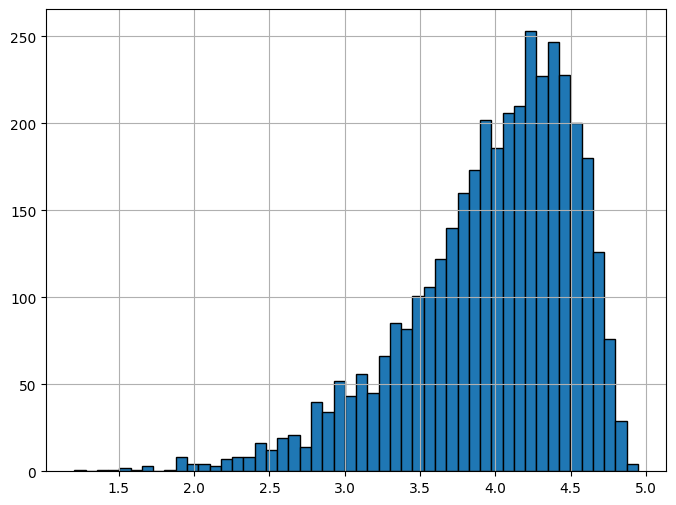

In [50]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

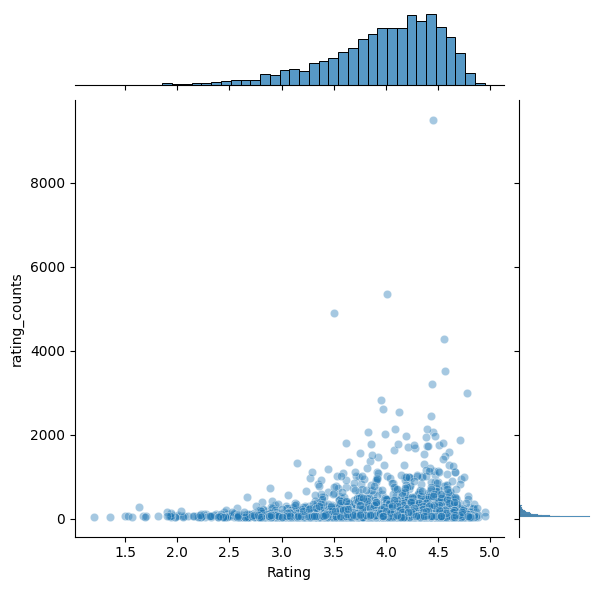

In [51]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

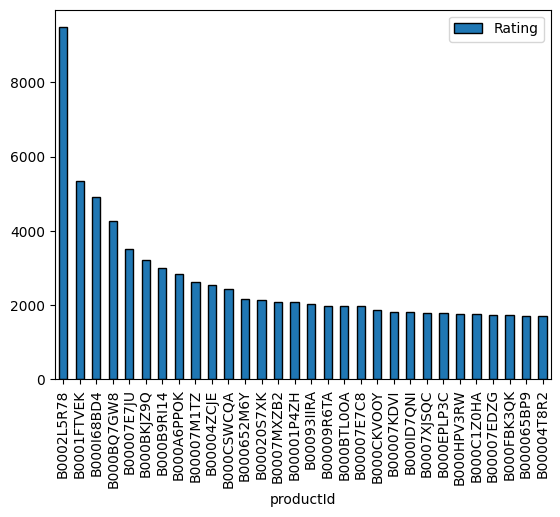

In [52]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering (Item-Item recommedation)

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [54]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357265 sha256=4a25488dcdd67d5ff90fd28e8893e8670aaa26a7ecbaaa2fb7a5129c72deb846
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [55]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [56]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [60]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [61]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [62]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [63]:
test_pred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [64]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [67]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0266076X6KPZ6CCHGVS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0293130VTX2ZXA70JQS,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A030530627MK66BD8V4LN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0571176384K8RBNKGF8O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
ratings_matrix.shape

(9832, 76)

In [69]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X1 = X

In [74]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
tSVD = TruncatedSVD(n_components=10)
decomposed_matrix = tSVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [75]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [76]:
X.index[75]

'B00000K135'

In [77]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [78]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [79]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['1400698987',
 'B000001ON6',
 'B00000J08Q',
 'B00000J1EP',
 'B00000J1F3',
 'B00000JBAT',
 'B00000JPPI']